In [41]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
print("TF: ", tf.__version__)
from tensorflow.keras import layers
from tensorflow.keras import models
from keras import Model
import keras

from pathlib import Path
from keras.preprocessing.image import load_img, img_to_array, image_dataset_from_directory
from tensorflow.keras.applications import vgg16, vgg19

import wandb
from wandb.keras import WandbCallback

TF:  2.7.0


In [42]:
def seed_everything():
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1' 
    np.random.seed(hash("improves reproducibility") % 2**32 - 1)
    tf.random.set_seed(hash("by removing stochasticity") % 2**32 - 1)

seed_everything()

In [43]:

# Get base project directory
project_path = Path(os.getcwd()).parent.parent
datapath = (project_path /'data/processed/')

CLASSES = {0 : 'yes', 1 : 'no'}
# Loops through pathlist and reads and resizes images
def read_image(pathlist : list, size : int)-> list:
    data = []
    for path in pathlist:
        image=load_img(path, color_mode='rgb', target_size=(size, size))
        image=img_to_array(image)
        # image=image/255.0
        data.append(image)
    data = np.asarray(data)
    return data

# Makes input and label data from folder locations.
# Loops through location "subfolder/CLASSES"
def get_sets(subfolder : str, CLASSES : dict, size : int) -> tuple[list, list]:
    folder_paths = []
    folder_labels = []
    labels = []
    for k,v in CLASSES.items():
        # input datapath generation
        folder_paths += list((datapath / f"2_split_{v}/{subfolder}").rglob("*"))
    # Label data generation
    folder_labels = [0 if x.stem.split('_')[1] == 'yes' else 1 for x in folder_paths]
    folder_labels = np.asarray(folder_labels, dtype=np.uint8)
    # Extract images from datapaths
    img_list = read_image(folder_paths, size)

    return img_list, folder_labels

def get_training_set(CLASSES : dict, size : int) -> tuple[list, list]:
    folder_paths = []
    folder_labels = []
    labels = []
    for k,v in CLASSES.items():
        # input datapath generation
        folder_paths += list((datapath / f"3_aug_{v}_train/").rglob("*"))
        # print(folder_paths)
    # Label data generation
    folder_labels = [0 if x.stem.split('_')[1] == 'yes' else 1 for x in folder_paths]
    # Extract images from datapaths
    img_list = read_image(folder_paths, size)

    return img_list, folder_labels

In [44]:
# Dataset inspect
# Read images to variables
size = 224
# X_train, y_train = get_training_set(CLASSES, size)
X_train, y_train = get_sets('train', CLASSES, size)
X_val, y_val = get_sets('val', CLASSES, size)
X_test, y_test = get_sets('test', CLASSES, size)

In [45]:
#@title
@tf.function
def preprocess(image: tf.Tensor, label: tf.Tensor):
    """
    Preprocess the image tensors and parse the labels
    """
    # Preprocess images
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    # Parse label
    label = tf.cast(label, tf.float32)
    
    return image, label


def prepare_dataloader(images: np.ndarray,
                       labels: np.ndarray,
                       loader_type: str='train',
                       batch_size: int=128):
    """
    Utility function to prepare dataloader.
    """
    images = vgg19.preprocess_input(images)
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))

    
    if loader_type=='train':
        dataset = dataset.shuffle(1024)

    dataloader = (
        dataset
        .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
        .batch(batch_size)
        .prefetch(tf.data.AUTOTUNE)
    )

    return dataloader

In [46]:
configs = dict(
    image_width = X_train[0].shape[0],
    image_height = X_train[0].shape[1],
    image_channels = X_train[0].shape[2],
    batch_size = 4,
    class_names = CLASSES,
    model_name = '', # set after model is defined
    pretrain_weights = 'imagenet',
    epochs = 5,
    init_learning_rate = 0.001,
    lr_decay_rate = 0.1,
    optimizer = 'adam',
    loss_fn = 'binary_crossentropy',
    metrics = ['accuracy'],
    earlystopping_patience = 5,
    architecture = "",# To be defined f"{base_model._name.upper()} global_average_pooling2d",
    dataset = "Brain_MRI_Images_for_Brain_Tumor_Detection"
)

In [47]:
trainloader = prepare_dataloader(X_train, y_train, 'train', configs.get('batch_size', 64))
validloader = prepare_dataloader(X_val, y_val, 'valid', configs.get('batch_size', 64))
testloader = prepare_dataloader(X_test, y_test, 'test', configs.get('batch_size', 64))

In [48]:
type(trainloader)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [49]:
# For demonstration purposes
log_full = True #@param {type:"boolean"}

if log_full:
    log_train_samples = len(X_train)
else:
    log_train_samples = 50

print(f'Number of train images : {log_train_samples} to be logged')

Number of train images : 125 to be logged


In [50]:
%%time

# Initialize a new W&B run
run = wandb.init(project="test_wandb",
                 entity="bex_team",
                 group="Pictures")

# Intialize a W&B Artifacts
ds = wandb.Artifact(configs["dataset"], "dataset")

# Initialize an empty table
train_table = wandb.Table(columns=[], data=[])
# Add training data
train_table.add_column('image', X_train[:log_train_samples])
# Add training label_id
train_table.add_column('label_id', np.asarray(y_train)[:log_train_samples])
# Add training class names
train_table.add_computed_columns(lambda ndx, row:{
    "images": wandb.Image(row["image"]),
    "class_names": configs['class_names'][(row["label_id"])]
    })

# Add the table to the Artifact
ds['train_data'] = train_table

# # Let's do the same for the validation data
valid_table = wandb.Table(columns=[], data=[])
valid_table.add_column('image', X_val)
valid_table.add_column('label_id', y_val)
valid_table.add_computed_columns(lambda ndx, row:{
    "images": wandb.Image(row["image"]),
    "class_name": configs['class_names'][(row["label_id"])]
    })
ds['valid_data'] = valid_table

# Save the dataset as an Artifact
ds.save()

# Finish the run
wandb.finish()

Wall time: 28.6 s


In [51]:
# def get_model(input_shape: tuple=(32, 32, 3),
#               output_activation: str='sigmoid'):

#     inputs = layers.Input(input_shape)

#     base_model = vgg19.VGG19(weights=configs['pretrain_weights'], include_top=False, input_shape=(224, 224, 3))
#     base_model.trainable = False

#     configs['architecture'] = base_model._name

#     inputs = layers.Input(shape=[X_train[0].shape[0], X_train[0].shape[1], 3])
#     x = tf.cast(inputs, tf.float32)
#     x = vgg19.preprocess_input(x)
#     x = base_model(x)
#     x = layers.GlobalAveragePooling2D()(x)
#     # x = Flatten()(x)
#     outputs = layers.Dense(1, activation=output_activation)(x)
#     model  = models.Model(inputs, outputs, name=f'Baseline_{base_model._name.upper()}')
#     return model

# tf.keras.backend.clear_session()
# model = get_model()
# model.summary()

In [52]:
# def get_model(input_shape: tuple=(32, 32, 3),
#               output_activation: str='sigmoid'):

#     inputs = layers.Input(input_shape)

#     base_model = vgg19.VGG19(weights=configs['pretrain_weights'], include_top=False, input_shape=(224, 224, 3))
#     base_model.trainable = False

#     configs['architecture'] = base_model._name

#     inputs = layers.Input(shape=[X_train[0].shape[0], X_train[0].shape[1], 3])
#     # x = tf.cast(inputs, tf.float32)
#     x = vgg19.preprocess_input(inputs)
#     for layer in base_model.layers:
#         x = layer(x)
#     # x = base_model(x, training=False)
#     x = layers.GlobalAveragePooling2D()(x)
#     # x = Flatten()(x)
#     outputs = layers.Dense(1, activation=output_activation)(x)
#     model  = models.Model(inputs, outputs, name=f'Baseline_{base_model._name.upper()}')
#     return model

# tf.keras.backend.clear_session()
# model = get_model()
# model.summary()

In [53]:
def get_model(input_shape: tuple=(32, 32, 3),
              output_activation: str='sigmoid'):
    shape = (X_train[0].shape[0], X_train[0].shape[1], 3)
    inputs = layers.Input(input_shape)

    base_model = vgg19.VGG19(weights=configs['pretrain_weights'], include_top=False, input_shape=shape)
    base_model.trainable = False

    configs['architecture'] = base_model._name

    # inputs = layers.Input(shape=list(shape))
    # inputs = base_model.layers[0].input
    # x = vgg19.preprocess_input(inputs)
    # for c, layer in enumerate(base_model.layers):
    #     if c >= 0:
    #         x = layer(x)
    
    x = layers.GlobalAveragePooling2D()(base_model.output)
    
    outputs = layers.Dense(1, activation=output_activation)(x)
    model  = models.Model(base_model.input, outputs, name=f'Baseline_{base_model._name.upper()}')
    return model

# tf.keras.backend.clear_session()
model = get_model()
model.summary()

Model: "Baseline_VGG19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)    

In [54]:
checkpoint_filepath = (Path(os.getcwd()) /'model_checkpoint/model_checkpoint')

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [55]:
earlystopper = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=configs['earlystopping_patience'], verbose=0, mode='auto',
    restore_best_weights=True
)

You can use `wandb.log` to log any useful metric/parameter that's not logged by `WandbCallback`. Here we are using a learning rate scheduler to exponentially decay the learning rate after 10 epochs. Notice the use of `wandb.log` to capture the learning rate and `commit=False` in particular.

You can learn more about `wandb.log` [here](https://docs.wandb.ai/guides/track/log).

def lr_scheduler(epoch, lr):
    # log the current learning rate onto W&B
    if wandb.run is None:
        raise wandb.Error("You must call wandb.init() before WandbCallback()")

    wandb.log({'learning_rate': lr}, commit=False)
    
    if epoch < 7:
        return lr
    else:
        return lr * tf.math.exp(-configs['lr_decay_rate'])

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

In [56]:
def train(config: dict,
          callbacks: list,
          verbose: int=0):
    """
    Utility function to train the model.

    Arguments:
        config (dict): Dictionary of hyperparameters.
        callbacks (list): List of callbacks passed to `model.fit`.
        verbose (int): 0 for silent and 1 for progress bar.
    """

    # Initalize model
    tf.keras.backend.clear_session()
    model = get_model(input_shape=(config.image_width, config.image_height, config.image_channels))
    config['model_name'] = model.name # set


    # Compile the model
    opt = tf.keras.optimizers.Adam(learning_rate=config.init_learning_rate)
    model.compile(optimizer=opt,
                  loss=config.loss_fn,
                  metrics=config.metrics)
# model.compile(loss="binary_crossentropy", optimizer=opt, metrics=metrics)
    # Train the model
    # _ = model.fit(np.array(X_train), np.array(y_train),
    #               epochs=config.epochs,
    #               validation_data=(np.array(X_val),np.array(y_val)),
    #               callbacks=callbacks,
    #               batch_size=config.batch_size,
    #               verbose=verbose)
    _ = model.fit(trainloader,
                  epochs=config.epochs,
                  validation_data=validloader,
                  callbacks=callbacks,
                  verbose=verbose)
    return model

In [58]:
# Initialize the W&B run
run = wandb.init(project='test_wandb', config=configs, job_type='Baseline')
config = wandb.config

# Define WandbCallback for experiment tracking
wandb_callback = WandbCallback(monitor='val_loss',
                               log_weights=True,
                               log_evaluation=True,
                               validation_steps=5,
                               )
# WandbCallback(data_type='image', training_data=(np.array(X_val),np.array(y_val)), labels=CLASSES, save_model=True, save_graph=True)
# callbacks
callbacks = [earlystopper, wandb_callback]#lr_callback

# Train
model = train(config, callbacks=callbacks, verbose=2)

# Evaluate the trained model
loss, acc = model.evaluate(validloader)
wandb.log({'evaluate/accuracy': acc})

# Close the W&B run.
wandb.finish()

Epoch 1/5
32/32 - 3s - loss: 1.2693 - accuracy: 0.5280 - val_loss: 0.8779 - val_accuracy: 0.6190 - 3s/epoch - 99ms/step
Epoch 2/5
32/32 - 2s - loss: 0.8361 - accuracy: 0.6240 - val_loss: 0.5793 - val_accuracy: 0.6905 - 2s/epoch - 72ms/step
Epoch 3/5
32/32 - 2s - loss: 0.6531 - accuracy: 0.7200 - val_loss: 0.5639 - val_accuracy: 0.7143 - 2s/epoch - 71ms/step
Epoch 4/5
32/32 - 3s - loss: 0.5239 - accuracy: 0.7520 - val_loss: 0.4149 - val_accuracy: 0.7857 - 3s/epoch - 79ms/step
Epoch 5/5
32/32 - 2s - loss: 0.4530 - accuracy: 0.7760 - val_loss: 0.4310 - val_accuracy: 0.7857 - 2s/epoch - 54ms/step
11/11 [==============================] - 0s 30ms/step - loss: 0.4310 - accuracy: 0.7857


accuracy,▁▄▆▇█
epoch,▁▃▅▆█
evaluate/accuracy,▁
loss,█▄▃▂▁
val_accuracy,▁▄▅██
val_loss,█▃▃▁▁
accuracy,0.776
best_epoch,3
best_val_loss,0.41486
epoch,4
evaluate/accuracy,0.78571


In [212]:
#@title
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
        # [model.inputs], [model.get_layer(configs['architecture']).get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def create_gradcam(image, model, last_conv_layer_name, pred_index=None):
    # Preprocess the image array
    image, _ = preprocess(tf.expand_dims(image, axis=0), 0)
    # image = tf.expand_dims(image, axis=0)#preprocess(tf.expand_dims(image, axis=0), 0)
    # Get GradCAM
    heatmap = make_gradcam_heatmap(image, model, last_conv_layer_name, pred_index)
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = tf.image.resize(jet_heatmap, size=(224,224))

    # Overlay
    superimposed_img = jet_heatmap * 0.1 + tf.squeeze(image, axis=0)
    superimposed_img = tf.clip_by_value(superimposed_img, 0.0, 1.0)

    return superimposed_img, tf.squeeze(image, axis=0), jet_heatmap

In [213]:
last_conv_layer_name = 'block5_conv4'

In [220]:
x_pre = vgg19.preprocess_input(X_train[0])
x = np.expand_dims(x_pre, axis=0)
# x = preprocess(tf.expand_dims(0, axis=0), 0)
# tf.squeeze(x, axis=0)

preds = model.predict(x)
img_hm = make_gradcam_heatmap(np.expand_dims(X_train[0], axis=0),model,last_conv_layer_name,0)

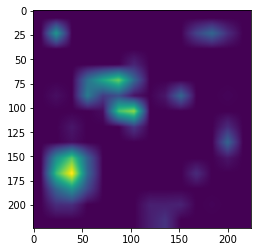

In [233]:
plt.imshow(tf.image.resize(np.expand_dims(img_hm, axis=2), size=(224,224)))

In [ ]:
def validation_processor(ndx, row):
    return {
        "input:image": wandb.Image(row["input"]),
        "target:class": class_table.index_ref(row["target"])
    }

def prediction_processor(ndx, row):
    # Get the validation image
    valid_image = np.array(row["val_row"].get_row()["input:image"].image)

    return {
        "output:class": class_table.index_ref(np.argmax(row["output"])),
        "gradcam": wandb.Image(create_gradcam(valid_image, model, last_conv_layer_name)),
        "output:logits": {class_name: value for (class_name, value) in zip(list(config.class_names.values()), row["output"].tolist())}
    }

In [ ]:
# Initialize the W&B run
run = wandb.init(project='test_wandb', config=configs, job_type='train', entity='bex_team')
config = wandb.config

# Get validation table
# data_art = run.use_artifact(f'{configs["dataset"]}:latest', type='dataset')
data_art = run.use_artifact('bex_team/test_wandb/Brain_MRI_Images_for_Brain_Tumor_Detection:latest', type='dataset')

valid_table = data_art.get("valid_data")

# Create a class table
class_table = wandb.Table(columns=[], data=[])
class_table.add_column("class_name", list(config.class_names.values()))

# Define WandbCallback for experiment tracking
wandb_callback = WandbCallback(
                    log_evaluation=True,
                    validation_row_processor=lambda ndx, row: validation_processor(ndx, row),
                    prediction_row_processor=lambda ndx, row: prediction_processor(ndx, row),
                    validation_steps=4,
                    save_model=False
                )

# callbacks
callbacks = [earlystopper, wandb_callback]#lr_callback

# Train
model = train(config, callbacks=callbacks, verbose=2)

# Evaluate the trained model
loss, acc = model.evaluate(validloader)
wandb.log({'evaluate/accuracy': acc})

# Close the W&B run.
wandb.finish()

Epoch 1/5
32/32 - 3s - loss: 1.3345 - accuracy: 0.5840 - val_loss: 1.2904 - val_accuracy: 0.6667 - 3s/epoch - 90ms/step
Epoch 2/5
32/32 - 1s - loss: 0.9412 - accuracy: 0.6640 - val_loss: 1.1218 - val_accuracy: 0.6667 - 1s/epoch - 47ms/step
Epoch 3/5
32/32 - 2s - loss: 0.7215 - accuracy: 0.7680 - val_loss: 0.9658 - val_accuracy: 0.6905 - 2s/epoch - 52ms/step
Epoch 4/5
32/32 - 1s - loss: 0.6176 - accuracy: 0.7680 - val_loss: 0.8577 - val_accuracy: 0.6905 - 1s/epoch - 44ms/step
Epoch 5/5
32/32 - 1s - loss: 0.4880 - accuracy: 0.8080 - val_loss: 0.7477 - val_accuracy: 0.7619 - 1s/epoch - 43ms/step
11/11 [==============================] - 0s 28ms/step - loss: 0.7477 - accuracy: 0.7619


accuracy,▁▃▇▇█
epoch,▁▃▅▆█
evaluate/accuracy,▁
loss,█▅▃▂▁
val_accuracy,▁▁▃▃█
val_loss,█▆▄▂▁
accuracy,0.808
best_epoch,4
best_val_loss,0.74772
epoch,4
evaluate/accuracy,0.7619
